In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import time
from sklearn import metrics
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
"""
train_data_path = "train_data/"
total_data = []

for file_name in glob.glob(train_data_path+"x*_plus_bi.csv"):
  print(file_name)
  with open(file_name, "r") as file:
    data = np.loadtxt(file, delimiter=",")
  #print(data.shape)
  data = data.reshape([495, 100, -1])
  total_data.append(data)
  

total_data = np.array(total_data)
print(total_data.shape)

with open(train_data_path +"images_data.npy", "wb") as f:
    np.save(f, total_data)
"""

with open("./norm_images_data_dim_16.npy", "rb") as f:
  total_data = np.load(f)
print(total_data.shape)

(576, 495, 100, 16)


In [4]:
np.random.seed(7777)

rand_idx = np.arange(total_data.shape[0])

np.random.shuffle(rand_idx)

cut = total_data.shape[0]//8

test_data = total_data[rand_idx[:cut]]
train_data = total_data[rand_idx[cut:]]

print(test_data.shape)
print(train_data.shape)

train_X = train_data[:, :, :, :-1]
train_Y = train_data[:, :, :, -1:]
test_X = test_data[:, :, :, :-1]
test_Y = test_data[:, :, :, -1:]


A = np.arange(49500, dtype=np.int32).reshape(495, 100)

print(A)
A_up = A + 1
A_down = A - 1
A_left = A - 100
A_right = A + 100

A_idx = np.stack([A_left, A_down, A_up, A_right], axis=-1)

A_idx[0, :, 0] = -1
A_idx[:, 0, 1] = -1
A_idx[:, -1, 2] = -1
A_idx[-1, :, 3] = -1

A_idx = A_idx.reshape([49500, -1, 1])
#print(A_idx)
print("A_idx:", A_idx.shape)

total_epochs = 200
batch_size = 4
units = 784
n_layers = 4
step_per_epoch = (train_X.shape[0]+batch_size-1)//batch_size

(72, 495, 100, 16)
(504, 495, 100, 16)
[[    0     1     2 ...    97    98    99]
 [  100   101   102 ...   197   198   199]
 [  200   201   202 ...   297   298   299]
 ...
 [49200 49201 49202 ... 49297 49298 49299]
 [49300 49301 49302 ... 49397 49398 49399]
 [49400 49401 49402 ... 49497 49498 49499]]
A_idx: (49500, 4, 1)


In [5]:



"""
assert False

for idx in range(test_X.shape[0]):

  fig = plt.figure(num=0, clear=True, figsize=[50, 10])
  ax = plt.subplot(1, 1, 1)

  cells = test_X[idx]
  print(cells.shape)
  cells = cells.reshape([-1, cells.shape[-1]])
  colors = np.zeros([cells.shape[0], 3])

  reds = test_Y[idx].flatten() > 0
  print(test_Y.shape )
  colors[reds] = [1.0, 0.0, 0.0]
  
  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)
  
    
  
  plt.tight_layout()
  plt.xlim([0.0, 5.0])
  plt.ylim([0.0, 1.0])
  #plt.savefig("./real_resnet_result/"+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")
  plt.show()
"""

'\nassert False\n\nfor idx in range(test_X.shape[0]):\n\n  fig = plt.figure(num=0, clear=True, figsize=[50, 10])\n  ax = plt.subplot(1, 1, 1)\n\n  cells = test_X[idx]\n  print(cells.shape)\n  cells = cells.reshape([-1, cells.shape[-1]])\n  colors = np.zeros([cells.shape[0], 3])\n\n  reds = test_Y[idx].flatten() > 0\n  print(test_Y.shape )\n  colors[reds] = [1.0, 0.0, 0.0]\n  \n  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)\n  \n    \n  \n  plt.tight_layout()\n  plt.xlim([0.0, 5.0])\n  plt.ylim([0.0, 1.0])\n  #plt.savefig("./real_resnet_result/"+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")\n  plt.show()\n'

In [6]:
class Batcher:
    def __init__(self, x, y, randomize = False):
        self.test_x = x
        self.test_y = y
        self.test_random_idx = None
        self.test_random = randomize
    
    def get_batch(self, batch_size):
        def shuffle_idx(x):
            if (self.test_random):
                np.random.shuffle(x)
        
        if (self.test_random_idx is None):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp = []
        targ = []
        while (batch_size > self.test_random_idx.shape[0]):
            inp.append(self.test_x[self.test_random_idx])
            targ.append(self.test_y[self.test_random_idx])
            batch_size -= self.test_random_idx.shape[0]
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp.append(self.test_x[self.test_random_idx[:batch_size]])
        targ.append(self.test_y[self.test_random_idx[:batch_size]])
        if (self.test_random_idx.shape[0] - batch_size == 0):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        else :
            self.test_random_idx = self.test_random_idx[batch_size:]
        inp = np.concatenate(inp, axis = 0)
        targ = np.concatenate(targ, axis = 0)
        return inp, targ
    def reset_random(self):
        self.test_random_idx = None

In [7]:
train_batcher = Batcher(train_X, train_Y, randomize=True)
test_batcher = Batcher(test_X, test_Y, randomize=False )

In [8]:
class GraphFNN(tf.keras.layers.Layer):
  def __init__(self, unit):
    super(GraphFNN, self).__init__()

    self.unit = unit
    
    self.d1 = tf.keras.layers.Dense(self.unit)
    self.b1 = tf.keras.layers.BatchNormalization()
    
  def call(self, x, A_idx, mask, training=False):
    # x = (bsz, 49500, n_feature)
    # A_idx = (bsz, 49500, 4, 1)
    # mask = (bsz, 49500, 4, 1): bool
    
    #features = (bsz, 49500, 4, n_feature)
    features = tf.gather_nd(x, A_idx, batch_dims=1)
    
    #x_tiled = (bsz, 49500, 4, n_feature)
    x_tiled = tf.expand_dims(x, 2)
    x_tiled = tf.tile(x_tiled, [1,1,A_idx.shape[2],1])
    
    #features = (bsz, 49500, 4, n_feature * 2)
    features = tf.concat([x_tiled, features], 3)

    #y1 = (bsz, 49500, 4, unit)
    y1 = self.d1(features)
    y1 = y1
    y1 = tf.nn.relu(y1)
    y1 = y1 * tf.cast(mask, tf.float32)
    #y1 = (bsz, 49500, unit)
    y1 = tf.reduce_sum(y1, axis=2)
    y1 = self.b1(y1, training=training)
    return y1
  

class My_GNN(tf.keras.Model):
  def __init__(self, unit=16, n_layers=12):
    super(My_GNN, self).__init__()
    
    self.unit = unit
    self.n_layers = n_layers
    
    #self.b1 = tf.keras.layers.BatchNormalization()
    
    self.gnn_layers = []
    for _ in range(self.n_layers):
        self.gnn_layers.append(GraphFNN(self.unit))
    
    self.f = tf.keras.layers.Dense(1)

  def call(self, x, A_idx, training = False):
    # x = (bsz, 49500, n_feature) : float32
    # A_idx = (bsz, 49500, 4, 1) :int
    
    #x = self.b1(x, training=training)
    
    #mask = (bsz, 49500, 4. 1)
    mask = A_idx >= 0
    A_idx = A_idx * tf.cast(mask, tf.int32)
    
    y = x
    for ly in self.gnn_layers:
      y = ly(y, A_idx, mask, training=training)
    y = self.f(y)
    return y




In [9]:

learning_rate = 0.0001

model = My_GNN(units, n_layers = n_layers)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                reduction="none")
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

checkpoint_dir = "./ckpt/gnn_"+f"u={units}_l={n_layers}"
checkpoint_prefix = os.path.join(checkpoint_dir, "tf")
checkpoint = tf.train.Checkpoint(model=model,
                                 optimizer = optimizer
                                )
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))





@tf.function
def training_step(inp, A_idx_tiled, targ):
  with tf.GradientTape() as tape:
    pred = model(inp, A_idx_tiled, training = True)
    #print(pred[0])
    loss = tf.reduce_mean(loss_object(targ, pred))
  variables = model.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  
  return loss

def validation():
  test_step = test_X.shape[0] // batch_size
  test_batcher.reset_random()
  total_loss = 0
  total_pred = []
  total_targ = []
  for i_step in range(test_step):
    inp, targ = test_batcher.get_batch(batch_size)
    inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
    A_idx_tiled = tf.tile(tf.expand_dims(A_idx, axis=0), [inp.shape[0], 1, 1, 1])
    pred = model(inp, A_idx_tiled, training = False)
    pred = tf.reshape(pred, targ.shape)
    loss = loss_object(targ, pred).numpy()
    loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
    loss = np.sum(loss)
    total_loss += loss
    total_pred.append(pred.numpy())
    total_targ.append(targ)
  if (test_X.shape[0] - (i_step+1) * batch_size) > 0:
    inp, targ = test_batcher.get_batch((test_X.shape[0] - (i_step+1) * batch_size))
    A_idx_tiled = np.tile(np.expand_dims(A_idx, axis=0), [inp.shape[0], 1, 1, 1])
    inp = np.reshape(inp, (inp.shape[0], 49500, -1))
    pred = model(inp, A_idx_tiled, training = False)
    pred = tf.reshape(pred, targ.shape)
    loss = loss_object(targ, pred).numpy()
    loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
    loss = np.sum(loss)
    total_loss += loss
    total_pred.append(pred.numpy())
    total_targ.append(targ)
    
  total_loss /= test_X.shape[0]
  
  total_pred = np.concatenate(total_pred, axis=0)
  total_targ = np.concatenate(total_targ, axis=0)
  
  total_pred_flat = total_pred.flatten()
  total_targ_flat = total_targ.flatten()
  
  fpr, tpr, thresholds = metrics.roc_curve(total_targ_flat, total_pred_flat, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  
  return total_loss, auc

2023-02-09 10:03:36.486566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 10:03:36.865786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46722 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6


2023-02-09 10:03:38.421582: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 0 Step 10 Loss: 0.8293
Epoch 0 Step 20 Loss: 0.7876
Epoch 0 Step 30 Loss: 0.7417
Epoch 0 Step 40 Loss: 0.6806
Epoch 0 Step 50 Loss: 0.6608
Epoch 0 Step 60 Loss: 0.6806
Epoch 0 Step 70 Loss: 0.6557
Epoch 0 Step 80 Loss: 0.6638
Epoch 0 Step 90 Loss: 0.6157
Epoch 0 Step 100 Loss: 0.6337
Epoch 0 Step 110 Loss: 0.6221
Epoch 0 Step 120 Loss: 0.6083
Time taken for 1 epoch 159.14640021324158 sec
Epoch 0 Loss: 0.6828
Validation Loss: 0.7114
Epoch 1 Step 10 Loss: 0.5865
Epoch 1 Step 20 Loss: 0.6009
Epoch 1 Step 30 Loss: 0.5860
Epoch 1 Step 40 Loss: 0.5958
Epoch 1 Step 50 Loss: 0.5852
Epoch 1 Step 60 Loss: 0.5671
Epoch 1 Step 70 Loss: 0.5700
Epoch 1 Step 80 Loss: 0.5630
Epoch 1 Step 90 Loss: 0.5576
Epoch 1 Step 100 Loss: 0.5440
Epoch 1 Step 110 Loss: 0.5430
Epoch 1 Step 120 Loss: 0.5583
Time taken for 1 epoch 156.67406010627747 sec
Epoch 1 Loss: 0.5698
Validation Loss: 0.5763
Epoch 2 Step 10 Loss: 0.5217
Epoch 2 Step 20 Loss: 0.5369
Epoch 2 Step 30 Loss: 0.5140
Epoch 2 Step 40 Loss: 0.5264


Epoch 18 Step 60 Loss: 0.1839
Epoch 18 Step 70 Loss: 0.1874
Epoch 18 Step 80 Loss: 0.2027
Epoch 18 Step 90 Loss: 0.1668
Epoch 18 Step 100 Loss: 0.1779
Epoch 18 Step 110 Loss: 0.2016
Epoch 18 Step 120 Loss: 0.1850
Time taken for 1 epoch 156.61879110336304 sec
Epoch 18 Loss: 0.1830
Validation Loss: 0.1868
Epoch 19 Step 10 Loss: 0.1708
Epoch 19 Step 20 Loss: 0.1722
Epoch 19 Step 30 Loss: 0.1712
Epoch 19 Step 40 Loss: 0.1737
Epoch 19 Step 50 Loss: 0.1945
Epoch 19 Step 60 Loss: 0.1739
Epoch 19 Step 70 Loss: 0.1802
Epoch 19 Step 80 Loss: 0.1611
Epoch 19 Step 90 Loss: 0.1887
Epoch 19 Step 100 Loss: 0.1628
Epoch 19 Step 110 Loss: 0.1727
Epoch 19 Step 120 Loss: 0.1706
Time taken for 1 epoch 156.56277537345886 sec
Epoch 19 Loss: 0.1755
Validation Loss: 0.1777
Epoch 20 Step 10 Loss: 0.1683
Epoch 20 Step 20 Loss: 0.1779
Epoch 20 Step 30 Loss: 0.1640
Epoch 20 Step 40 Loss: 0.1641
Epoch 20 Step 50 Loss: 0.1538
Epoch 20 Step 60 Loss: 0.1633
Epoch 20 Step 70 Loss: 0.1745
Epoch 20 Step 80 Loss: 0.1633


Epoch 36 Step 70 Loss: 0.1107
Epoch 36 Step 80 Loss: 0.1114
Epoch 36 Step 90 Loss: 0.1119
Epoch 36 Step 100 Loss: 0.0966
Epoch 36 Step 110 Loss: 0.1463
Epoch 36 Step 120 Loss: 0.1117
Time taken for 1 epoch 156.5871067047119 sec
Epoch 36 Loss: 0.1090
Validation Loss: 0.1129
Epoch 37 Step 10 Loss: 0.1099
Epoch 37 Step 20 Loss: 0.1149
Epoch 37 Step 30 Loss: 0.1069
Epoch 37 Step 40 Loss: 0.1074
Epoch 37 Step 50 Loss: 0.1013
Epoch 37 Step 60 Loss: 0.1106
Epoch 37 Step 70 Loss: 0.0997
Epoch 37 Step 80 Loss: 0.1023
Epoch 37 Step 90 Loss: 0.1155
Epoch 37 Step 100 Loss: 0.0965
Epoch 37 Step 110 Loss: 0.1029
Epoch 37 Step 120 Loss: 0.0983
Time taken for 1 epoch 156.66908025741577 sec
Epoch 37 Loss: 0.1072
Validation Loss: 0.1108
Epoch 38 Step 10 Loss: 0.1026
Epoch 38 Step 20 Loss: 0.1066
Epoch 38 Step 30 Loss: 0.0977
Epoch 38 Step 40 Loss: 0.1119
Epoch 38 Step 50 Loss: 0.1066
Epoch 38 Step 60 Loss: 0.1219
Epoch 38 Step 70 Loss: 0.0957
Epoch 38 Step 80 Loss: 0.1053
Epoch 38 Step 90 Loss: 0.0949
E

Epoch 54 Step 80 Loss: 0.0827
Epoch 54 Step 90 Loss: 0.0851
Epoch 54 Step 100 Loss: 0.0944
Epoch 54 Step 110 Loss: 0.0787
Epoch 54 Step 120 Loss: 0.0798
Time taken for 1 epoch 156.6678283214569 sec
Epoch 54 Loss: 0.0850
Validation Loss: 0.0888
Epoch 55 Step 10 Loss: 0.0856
Epoch 55 Step 20 Loss: 0.0865
Epoch 55 Step 30 Loss: 0.0784
Epoch 55 Step 40 Loss: 0.0800
Epoch 55 Step 50 Loss: 0.0818
Epoch 55 Step 60 Loss: 0.0845
Epoch 55 Step 70 Loss: 0.0828
Epoch 55 Step 80 Loss: 0.0752
Epoch 55 Step 90 Loss: 0.0773
Epoch 55 Step 100 Loss: 0.0743
Epoch 55 Step 110 Loss: 0.0928
Epoch 55 Step 120 Loss: 0.0764
Time taken for 1 epoch 156.54683136940002 sec
Epoch 55 Loss: 0.0844
Validation Loss: 0.0878
Epoch 56 Step 10 Loss: 0.0815
Epoch 56 Step 20 Loss: 0.0718
Epoch 56 Step 30 Loss: 0.0751
Epoch 56 Step 40 Loss: 0.0770
Epoch 56 Step 50 Loss: 0.0911
Epoch 56 Step 60 Loss: 0.0846
Epoch 56 Step 70 Loss: 0.1342
Epoch 56 Step 80 Loss: 0.0781
Epoch 56 Step 90 Loss: 0.0777
Epoch 56 Step 100 Loss: 0.0854


Epoch 72 Step 90 Loss: 0.0732
Epoch 72 Step 100 Loss: 0.0719
Epoch 72 Step 110 Loss: 0.0665
Epoch 72 Step 120 Loss: 0.0727
Time taken for 1 epoch 156.53784608840942 sec
Epoch 72 Loss: 0.0737
Validation Loss: 0.0780
Epoch 73 Step 10 Loss: 0.0788
Epoch 73 Step 20 Loss: 0.0780
Epoch 73 Step 30 Loss: 0.0681
Epoch 73 Step 40 Loss: 0.0745
Epoch 73 Step 50 Loss: 0.0723
Epoch 73 Step 60 Loss: 0.0706
Epoch 73 Step 70 Loss: 0.0696
Epoch 73 Step 80 Loss: 0.0676
Epoch 73 Step 90 Loss: 0.0713
Epoch 73 Step 100 Loss: 0.0740
Epoch 73 Step 110 Loss: 0.0627
Epoch 73 Step 120 Loss: 0.0736
Time taken for 1 epoch 156.6712520122528 sec
Epoch 73 Loss: 0.0735
Validation Loss: 0.0775
Epoch 74 Step 10 Loss: 0.0716
Epoch 74 Step 20 Loss: 0.0839
Epoch 74 Step 30 Loss: 0.0737
Epoch 74 Step 40 Loss: 0.0819
Epoch 74 Step 50 Loss: 0.0675
Epoch 74 Step 60 Loss: 0.0626
Epoch 74 Step 70 Loss: 0.0824
Epoch 74 Step 80 Loss: 0.0700
Epoch 74 Step 90 Loss: 0.0746
Epoch 74 Step 100 Loss: 0.0690
Epoch 74 Step 110 Loss: 0.0686

Epoch 90 Step 100 Loss: 0.0673
Epoch 90 Step 110 Loss: 0.0564
Epoch 90 Step 120 Loss: 0.0692
Time taken for 1 epoch 156.54920721054077 sec
Epoch 90 Loss: 0.0677
Validation Loss: 0.0719
Epoch 91 Step 10 Loss: 0.0673
Epoch 91 Step 20 Loss: 0.0759
Epoch 91 Step 30 Loss: 0.0585
Epoch 91 Step 40 Loss: 0.0657
Epoch 91 Step 50 Loss: 0.0689
Epoch 91 Step 60 Loss: 0.1284
Epoch 91 Step 70 Loss: 0.0672
Epoch 91 Step 80 Loss: 0.0624
Epoch 91 Step 90 Loss: 0.0558
Epoch 91 Step 100 Loss: 0.0648
Epoch 91 Step 110 Loss: 0.0595
Epoch 91 Step 120 Loss: 0.0572
Time taken for 1 epoch 156.55303597450256 sec
Epoch 91 Loss: 0.0672
Validation Loss: 0.0715
Epoch 92 Step 10 Loss: 0.1228
Epoch 92 Step 20 Loss: 0.0719
Epoch 92 Step 30 Loss: 0.0606
Epoch 92 Step 40 Loss: 0.0717
Epoch 92 Step 50 Loss: 0.0599
Epoch 92 Step 60 Loss: 0.0687
Epoch 92 Step 70 Loss: 0.0734
Epoch 92 Step 80 Loss: 0.0581
Epoch 92 Step 90 Loss: 0.0747
Epoch 92 Step 100 Loss: 0.0777
Epoch 92 Step 110 Loss: 0.0582
Epoch 92 Step 120 Loss: 0.06

Epoch 108 Step 70 Loss: 0.1168
Epoch 108 Step 80 Loss: 0.0682
Epoch 108 Step 90 Loss: 0.0576
Epoch 108 Step 100 Loss: 0.0584
Epoch 108 Step 110 Loss: 0.0727
Epoch 108 Step 120 Loss: 0.0628
Time taken for 1 epoch 156.46760416030884 sec
Epoch 108 Loss: 0.0635
Validation Loss: 0.0679
Epoch 109 Step 10 Loss: 0.0605
Epoch 109 Step 20 Loss: 0.0556
Epoch 109 Step 30 Loss: 0.0591
Epoch 109 Step 40 Loss: 0.0649
Epoch 109 Step 50 Loss: 0.0595
Epoch 109 Step 60 Loss: 0.0575
Epoch 109 Step 70 Loss: 0.0598
Epoch 109 Step 80 Loss: 0.0578
Epoch 109 Step 90 Loss: 0.0641
Epoch 109 Step 100 Loss: 0.0602
Epoch 109 Step 110 Loss: 0.0633
Epoch 109 Step 120 Loss: 0.0725
Time taken for 1 epoch 156.6663053035736 sec
Epoch 109 Loss: 0.0633
Validation Loss: 0.0677
Epoch 110 Step 10 Loss: 0.0723
Epoch 110 Step 20 Loss: 0.0688
Epoch 110 Step 30 Loss: 0.0589
Epoch 110 Step 40 Loss: 0.0766
Epoch 110 Step 50 Loss: 0.0583
Epoch 110 Step 60 Loss: 0.0655
Epoch 110 Step 70 Loss: 0.0656
Epoch 110 Step 80 Loss: 0.0563
Epo

Validation Loss: 0.0651
Epoch 126 Step 10 Loss: 0.0554
Epoch 126 Step 20 Loss: 0.0629
Epoch 126 Step 30 Loss: 0.0771
Epoch 126 Step 40 Loss: 0.0645
Epoch 126 Step 50 Loss: 0.0702
Epoch 126 Step 60 Loss: 0.0589
Epoch 126 Step 70 Loss: 0.0561
Epoch 126 Step 80 Loss: 0.0701
Epoch 126 Step 90 Loss: 0.0729
Epoch 126 Step 100 Loss: 0.0663
Epoch 126 Step 110 Loss: 0.0608
Epoch 126 Step 120 Loss: 0.0626
Time taken for 1 epoch 156.50064730644226 sec
Epoch 126 Loss: 0.0606
Validation Loss: 0.0649
Epoch 127 Step 10 Loss: 0.0498
Epoch 127 Step 20 Loss: 0.0580
Epoch 127 Step 30 Loss: 0.0599
Epoch 127 Step 40 Loss: 0.0559
Epoch 127 Step 50 Loss: 0.0570
Epoch 127 Step 60 Loss: 0.0548
Epoch 127 Step 70 Loss: 0.0568
Epoch 127 Step 80 Loss: 0.0662
Epoch 127 Step 90 Loss: 0.0664
Epoch 127 Step 100 Loss: 0.0566
Epoch 127 Step 110 Loss: 0.0687
Epoch 127 Step 120 Loss: 0.0607
Time taken for 1 epoch 156.51418828964233 sec
Epoch 127 Loss: 0.0605
Validation Loss: 0.0649
Epoch 128 Step 10 Loss: 0.0604
Epoch 128

Epoch 143 Step 90 Loss: 0.0599
Epoch 143 Step 100 Loss: 0.0544
Epoch 143 Step 110 Loss: 0.0628
Epoch 143 Step 120 Loss: 0.0559
Time taken for 1 epoch 156.53281116485596 sec
Epoch 143 Loss: 0.0587
Validation Loss: 0.0631
Epoch 144 Step 10 Loss: 0.0613
Epoch 144 Step 20 Loss: 0.0638
Epoch 144 Step 30 Loss: 0.0476
Epoch 144 Step 40 Loss: 0.0661
Epoch 144 Step 50 Loss: 0.0531
Epoch 144 Step 60 Loss: 0.0555
Epoch 144 Step 70 Loss: 0.0522
Epoch 144 Step 80 Loss: 0.0528
Epoch 144 Step 90 Loss: 0.0573
Epoch 144 Step 100 Loss: 0.0575
Epoch 144 Step 110 Loss: 0.0600
Epoch 144 Step 120 Loss: 0.0592
Time taken for 1 epoch 156.60316371917725 sec
Epoch 144 Loss: 0.0586
Validation Loss: 0.0631
Epoch 145 Step 10 Loss: 0.0526
Epoch 145 Step 20 Loss: 0.0590
Epoch 145 Step 30 Loss: 0.0742
Epoch 145 Step 40 Loss: 0.0520
Epoch 145 Step 50 Loss: 0.0474
Epoch 145 Step 60 Loss: 0.0522
Epoch 145 Step 70 Loss: 0.0493
Epoch 145 Step 80 Loss: 0.0508
Epoch 145 Step 90 Loss: 0.0658
Epoch 145 Step 100 Loss: 0.0469
E

Epoch 161 Step 20 Loss: 0.0566
Epoch 161 Step 30 Loss: 0.0642
Epoch 161 Step 40 Loss: 0.0711
Epoch 161 Step 50 Loss: 0.0553
Epoch 161 Step 60 Loss: 0.0598
Epoch 161 Step 70 Loss: 0.0609
Epoch 161 Step 80 Loss: 0.0534
Epoch 161 Step 90 Loss: 0.0520
Epoch 161 Step 100 Loss: 0.0444
Epoch 161 Step 110 Loss: 0.0599
Epoch 161 Step 120 Loss: 0.0554
Time taken for 1 epoch 156.779310464859 sec
Epoch 161 Loss: 0.0570
Validation Loss: 0.0616
Epoch 162 Step 10 Loss: 0.0512
Epoch 162 Step 20 Loss: 0.0658
Epoch 162 Step 30 Loss: 0.0702
Epoch 162 Step 40 Loss: 0.0474
Epoch 162 Step 50 Loss: 0.0704
Epoch 162 Step 60 Loss: 0.0588
Epoch 162 Step 70 Loss: 0.0506
Epoch 162 Step 80 Loss: 0.0498
Epoch 162 Step 90 Loss: 0.0415
Epoch 162 Step 100 Loss: 0.0659
Epoch 162 Step 110 Loss: 0.0460
Epoch 162 Step 120 Loss: 0.0536
Time taken for 1 epoch 156.57578420639038 sec
Epoch 162 Loss: 0.0567
Validation Loss: 0.0614
Epoch 163 Step 10 Loss: 0.0598
Epoch 163 Step 20 Loss: 0.0667
Epoch 163 Step 30 Loss: 0.0551
Epoc

Epoch 178 Step 100 Loss: 0.0665
Epoch 178 Step 110 Loss: 0.0565
Epoch 178 Step 120 Loss: 0.0580
Time taken for 1 epoch 156.65302276611328 sec
Epoch 178 Loss: 0.0557
Validation Loss: 0.0602
Epoch 179 Step 10 Loss: 0.0536
Epoch 179 Step 20 Loss: 0.0524
Epoch 179 Step 30 Loss: 0.0486
Epoch 179 Step 40 Loss: 0.0614
Epoch 179 Step 50 Loss: 0.0536
Epoch 179 Step 60 Loss: 0.0599
Epoch 179 Step 70 Loss: 0.0507
Epoch 179 Step 80 Loss: 0.0507
Epoch 179 Step 90 Loss: 0.0495
Epoch 179 Step 100 Loss: 0.0568
Epoch 179 Step 110 Loss: 0.0504
Epoch 179 Step 120 Loss: 0.0503
Time taken for 1 epoch 156.65108489990234 sec
Epoch 179 Loss: 0.0553
Validation Loss: 0.0600
Epoch 180 Step 10 Loss: 0.0548
Epoch 180 Step 20 Loss: 0.0674
Epoch 180 Step 30 Loss: 0.0495
Epoch 180 Step 40 Loss: 0.0475
Epoch 180 Step 50 Loss: 0.0468
Epoch 180 Step 60 Loss: 0.0569
Epoch 180 Step 70 Loss: 0.0635
Epoch 180 Step 80 Loss: 0.0553
Epoch 180 Step 90 Loss: 0.0587
Epoch 180 Step 100 Loss: 0.0591
Epoch 180 Step 110 Loss: 0.0619


Epoch 196 Step 30 Loss: 0.1121
Epoch 196 Step 40 Loss: 0.0553
Epoch 196 Step 50 Loss: 0.0542
Epoch 196 Step 60 Loss: 0.0517
Epoch 196 Step 70 Loss: 0.0613
Epoch 196 Step 80 Loss: 0.0501
Epoch 196 Step 90 Loss: 0.0634
Epoch 196 Step 100 Loss: 0.0492
Epoch 196 Step 110 Loss: 0.0477
Epoch 196 Step 120 Loss: 0.0422
Time taken for 1 epoch 156.5983350276947 sec
Epoch 196 Loss: 0.0544
Validation Loss: 0.0589
Epoch 197 Step 10 Loss: 0.0528
Epoch 197 Step 20 Loss: 0.0659
Epoch 197 Step 30 Loss: 0.0559
Epoch 197 Step 40 Loss: 0.0439
Epoch 197 Step 50 Loss: 0.0472
Epoch 197 Step 60 Loss: 0.0498
Epoch 197 Step 70 Loss: 0.0578
Epoch 197 Step 80 Loss: 0.0444
Epoch 197 Step 90 Loss: 0.0482
Epoch 197 Step 100 Loss: 0.0707
Epoch 197 Step 110 Loss: 0.0450
Epoch 197 Step 120 Loss: 0.0561
Time taken for 1 epoch 156.6354238986969 sec
Epoch 197 Loss: 0.0545
Validation Loss: 0.0590
Epoch 198 Step 10 Loss: 0.0499
Epoch 198 Step 20 Loss: 0.0534
Epoch 198 Step 30 Loss: 0.0628
Epoch 198 Step 40 Loss: 0.0483
Epoc

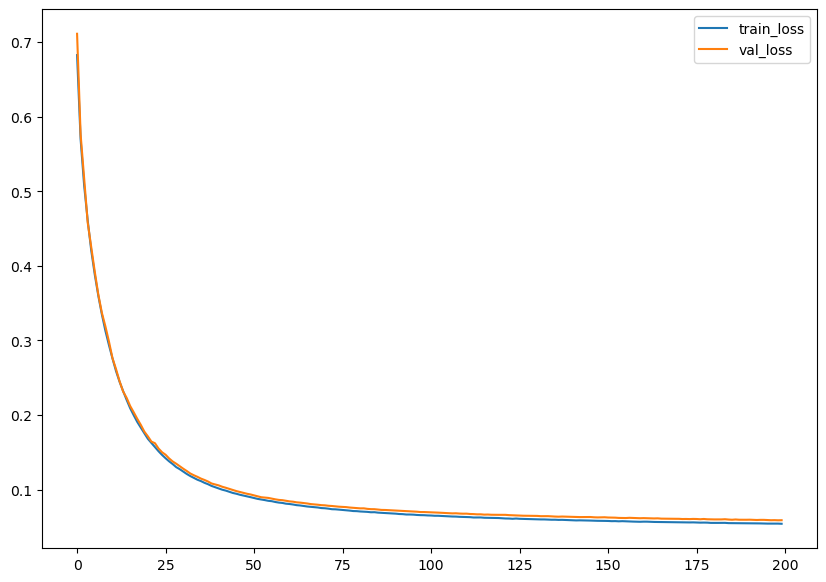

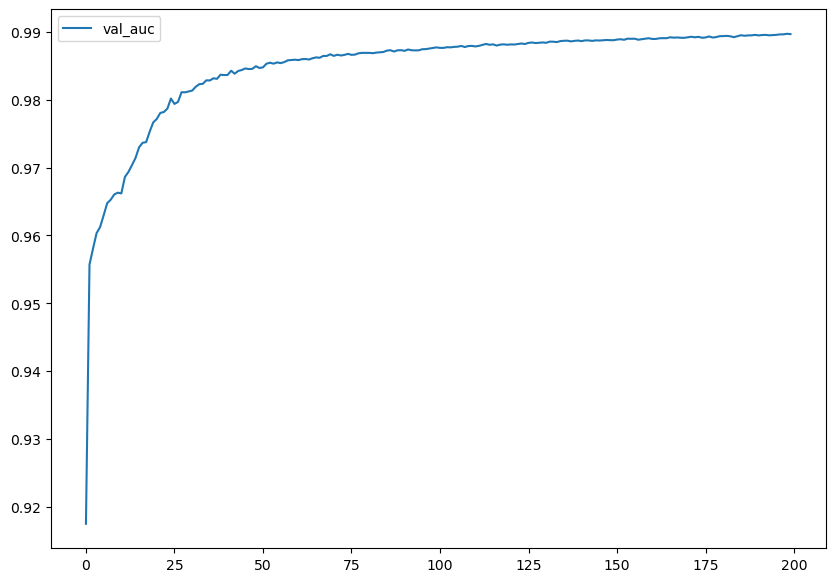

In [10]:
train_losses = []
val_losses = []

val_aucs = []

for ep in range(total_epochs):
  train_batcher.reset_random()
  total_loss = 0
  start = time.time()
  for i_step in range(step_per_epoch):
    inp, targ = train_batcher.get_batch(batch_size)
    inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
    A_idx_tiled = tf.tile(tf.expand_dims(A_idx, axis=0), [inp.shape[0], 1, 1, 1])
    targ = tf.reshape(targ, (targ.shape[0], 49500, -1))
    loss = training_step(inp, A_idx_tiled, targ)
    
    total_loss += loss

    if (i_step+1) % 10 == 0:
      print(f"Epoch {ep} Step {i_step+1} Loss: {loss.numpy():.4f}")
  total_loss /= step_per_epoch
  print(f"Time taken for 1 epoch {time.time()-start} sec")
  print(f"Epoch {ep} Loss: {total_loss.numpy():.4f}")
  train_losses.append(total_loss)
  
  val_loss, val_auc = validation()
  
  print(f"Validation Loss: {val_loss:.4f}")
  
  checkpoint.save(file_prefix=checkpoint_prefix)
  
  val_losses.append(val_loss)
  val_aucs.append(val_auc)
  
import matplotlib.pyplot as plt

plt.figure(figsize = [10, 7])
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.show()

plt.figure(figsize = [10, 7])
plt.plot(val_aucs, label="val_auc")
plt.legend()
plt.show()

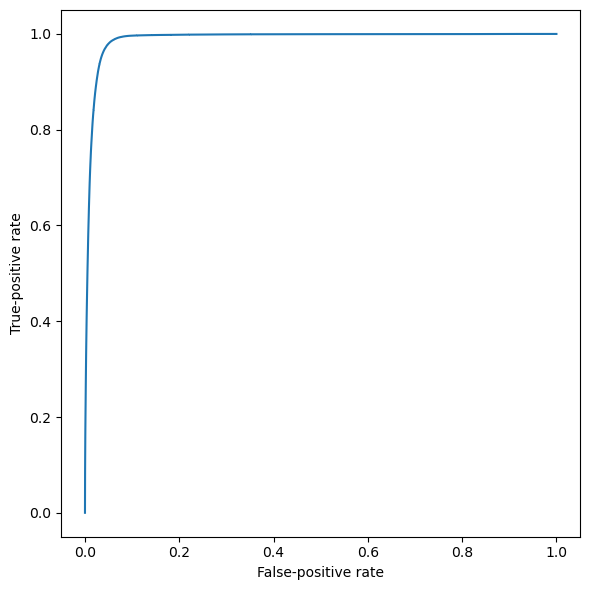

In [11]:

test_step = test_X.shape[0] // batch_size
test_batcher.reset_random()
total_loss = 0
total_test_inp = []
total_pred = []
total_targ = []
for i_step in range(test_step):
  inp, targ = test_batcher.get_batch(batch_size)
  inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
  A_idx_tiled = tf.tile(tf.expand_dims(A_idx, axis=0), [inp.shape[0], 1, 1, 1])
  pred = model(inp, A_idx_tiled, training = False)
  pred = tf.reshape(pred, targ.shape)
  loss = loss_object(targ, pred).numpy()
  loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
  loss = np.sum(loss)
  total_loss += loss
  total_pred.append(pred.numpy())
  total_targ.append(targ)
if (test_X.shape[0] - (i_step+1) * batch_size) > 0:
  inp, targ = test_batcher.get_batch((test_X.shape[0] - (i_step+1) * batch_size))
  inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
  A_idx_tiled = tf.tile(tf.expand_dims(A_idx, axis=0), [inp.shape[0], 1, 1, 1])
  pred = model(inp, A_idx_tiled, training = False)
  pred = tf.reshape(pred, targ.shape)
  loss = loss_object(targ, pred).numpy()
  loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
  loss = np.sum(loss)
  total_loss += loss
  total_pred.append(pred.numpy())
  total_targ.append(targ)

total_loss /= test_X.shape[0]

total_pred = np.concatenate(total_pred, axis=0)
total_targ = np.concatenate(total_targ, axis=0)

total_pred_flat = total_pred.flatten()
total_targ_flat = total_targ.flatten()

fpr, tpr, thresholds = metrics.roc_curve(total_targ_flat, total_pred_flat, pos_label=1)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel("False-positive rate")
plt.ylabel("True-positive rate")
plt.tight_layout()

plt.show()

(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)

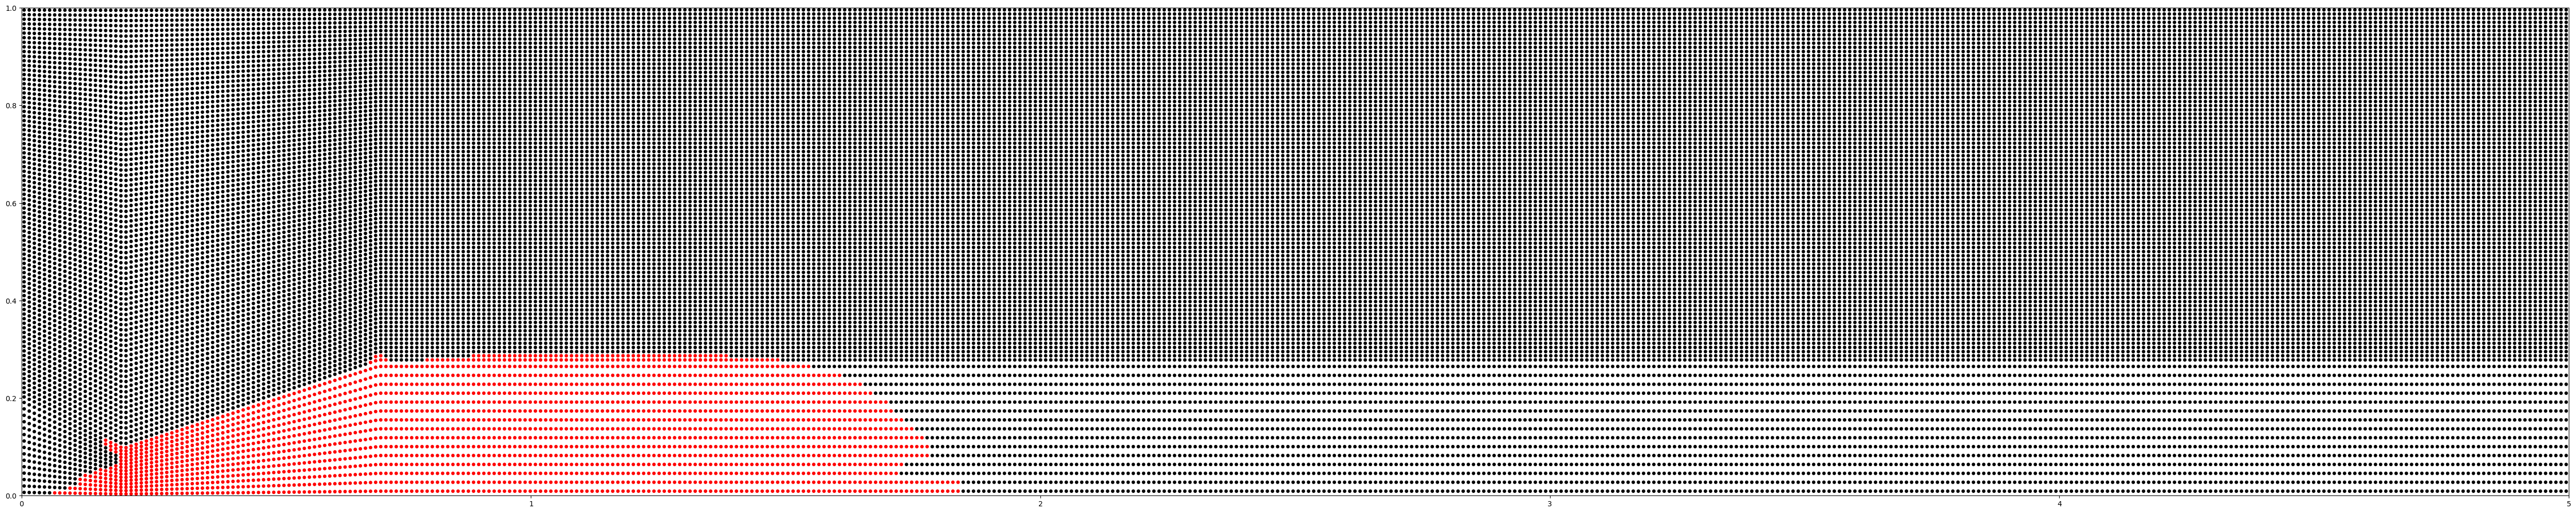

In [12]:

hits = 0
trials = 0


with open("./images_data.npy", "rb") as f:
  xys = np.load(f)
  test_xys = xys[rand_idx[:cut]]

fig_path = f"./gnn_"+f"u={units}_l={n_layers}_result/"

if not os.path.exists(fig_path):
    os.mkdir(fig_path)




for idx in range(test_X.shape[0]):

  fig = plt.figure(num=0, clear=True, figsize=[50, 10])
  ax = plt.subplot(1, 1, 1)

  cells = test_xys[idx]
  print(cells.shape)
  cells = cells.reshape([-1, cells.shape[-1]])
  colors = np.zeros([cells.shape[0], 3])
  total_pred_flat = total_pred[idx].flatten()
  sorted_pred = np.sort(total_pred_flat)
  thres = sorted_pred[-np.size(total_pred_flat)//20]
  reds = total_pred_flat > thres
  
  #reds = total_targ[idx].flatten() > 0
  #reds = test_Y[idx].flatten() > 0
  print(total_targ[idx].shape)
  
  trials += np.size(total_targ[idx])
  hits += np.sum(total_targ[idx].flatten() == reds)
  
  
  colors[reds] = [1.0, 0.0, 0.0]
  
  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)
  
    
  
  plt.tight_layout()
  plt.xlim([0.0, 5.0])
  plt.ylim([0.0, 1.0])
  plt.savefig(fig_path+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")
  #plt.show()
  #assert False
  
print("acc:", hits / trials)

In [ ]:
#no norm data
#u=24, l=12 acc: 0.9687800224466891
#u=128, l=12 acc: 0.9739410774410775
#u=96, l=12 bn acc: 0.956942760942761

#new) norm data
#u=128 l=12 acc: 0.97121212
#u=96 l=16 bsz=12 acc: 0.9675112233445566
#u=196 l=12 bsz=12 acc: 0.9736150392817059
#u=256 l=9 bsz=8 acc: 0.9749
#u=256 l=4 bsz=16 acc: 0.9726245
#u=384 l=3 bsz=12 acc: 0.97331
#u=512 l=5 bsz=8 acc: 0.97579461
#u=784 l=4 bsz=4 acc: 0.976069584

(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100, 22)
(495, 100,

ZeroDivisionError: division by zero

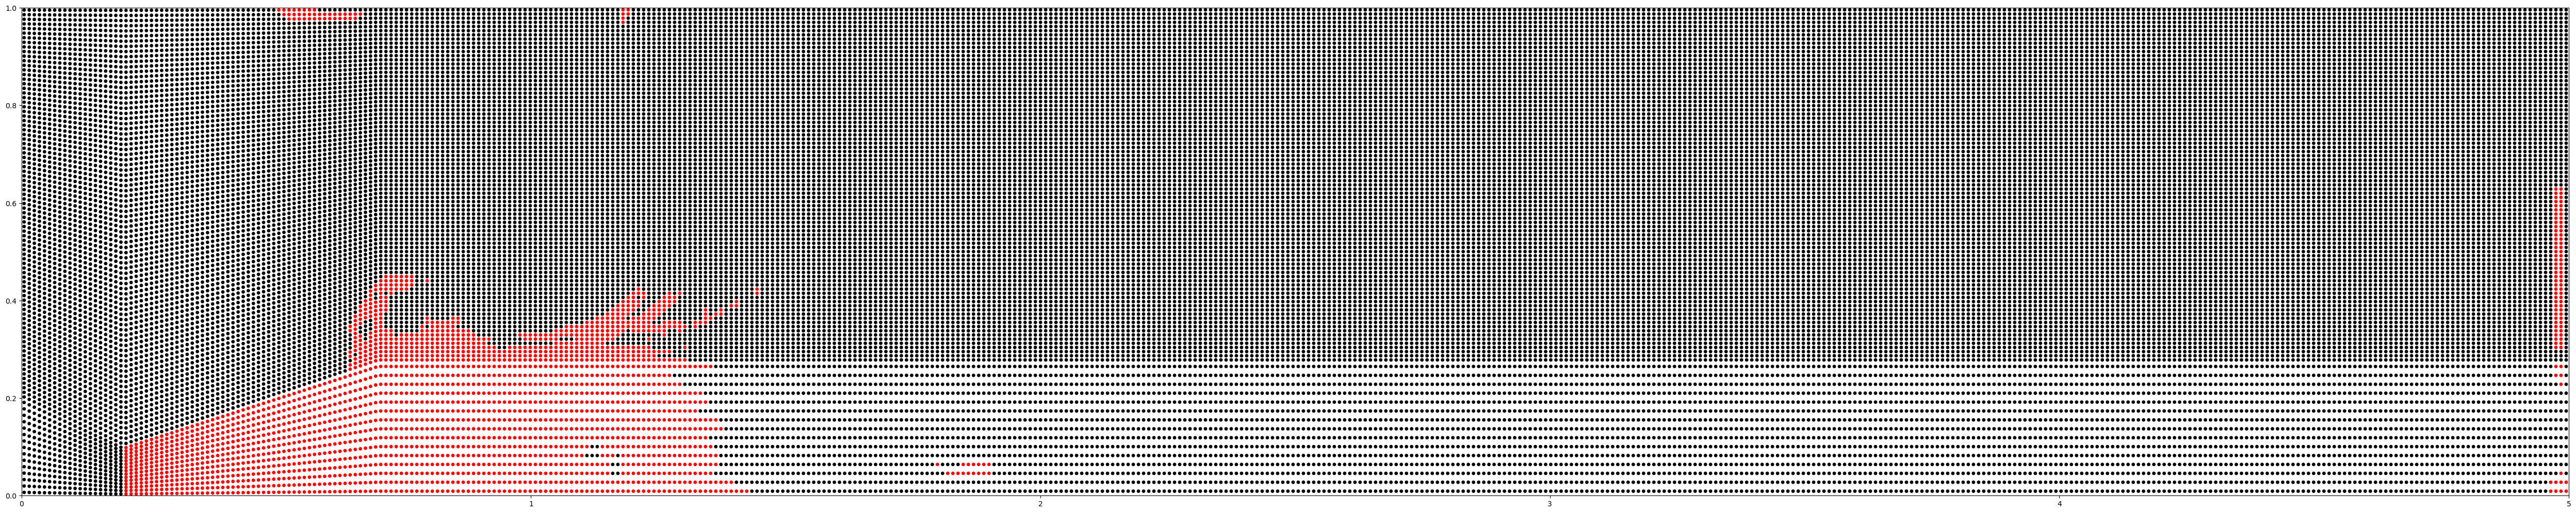

In [8]:
hits = 0
trials = 0


with open("./images_data.npy", "rb") as f:
  xys = np.load(f)
  test_xys = xys[rand_idx[:cut]]

fig_path = f"./labels_image/"

if not os.path.exists(fig_path):
    os.mkdir(fig_path)




for idx in range(test_X.shape[0]):

  fig = plt.figure(num=0, clear=True, figsize=[50, 10])
  ax = plt.subplot(1, 1, 1)

  cells = test_xys[idx]
  print(cells.shape)
  cells = cells.reshape([-1, cells.shape[-1]])
  colors = np.zeros([cells.shape[0], 3])
  
  #reds = total_targ[idx].flatten() > 0
  reds = test_Y[idx].flatten() > 0
  
  #trials += np.size(total_targ[idx])
  #hits += np.sum(total_targ[idx].flatten() == reds)
  
  
  colors[reds] = [1.0, 0.0, 0.0]
  
  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)
  
    
  
  plt.tight_layout()
  plt.xlim([0.0, 5.0])
  plt.ylim([0.0, 1.0])
  plt.savefig(fig_path+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")
  #plt.show()
  #assert False
  
print("acc:", hits / trials)

In [29]:
total_pred[idx].shape

(495, 100, 1)

In [28]:
a = np.array([[[1,2, 3], [4, 5, 6]], [[7, 8, 9],[10, 11, 12]]])

print(a)
print(a.shape)

print(a[:, -1].flatten())

print(a.reshape((-1, 3)))

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
(2, 2, 3)
[ 4  5  6 10 11 12]
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


In [12]:
checkpoint.save(file_prefix=checkpoint_prefix)

'./ckpt/resnet_u=64_l=12\\tf-1'

In [13]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))